# Homework 5 (appendix)
### Author: Mateusz Sieniawski

In [1]:
import shap
import random
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from pdpbox import pdp, get_dataset, info_plots
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from collections.abc import Iterable

np.random.seed(42)
random.seed(42)

TRIALS = 20

In [2]:
df = pd.read_csv("kc_house_data.csv")
df = df.drop(["id", "date", "bedrooms"], axis=1)
df = df.dropna()

target_col = "price"
X = df.drop([target_col], axis=1)
Y = df[[target_col]]

In [3]:
# split data into train and test sets
seed = 42
test_size = 0.2
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, train_size=train_size, random_state=seed)

## XGBoost

In [4]:
model = xgb.XGBRegressor(eval_metric="rmsle")
model.fit(X_train, y_train)
print(model)

y_pred = model.predict(X_test)
xgboost_loss = msle(y_test, y_pred)
print(f"Loss: {xgboost_loss:.3f}")

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmsle',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Loss: 0.031


In [5]:
xgboost_variable_importance = {}

for col in range(len(X_train.columns)):
    loss = 0
    for _ in range(TRIALS):
        X_shuffled = X_train.copy()
        X_shuffled = X_shuffled.reset_index(drop=True)
        X_shuffled.iloc[:, col] = X_shuffled.iloc [:, col] .sample (frac = 1) .reset_index (drop = True)
        X_shuffled = X_shuffled.reset_index(drop=True)

        model = xgb.XGBRegressor(eval_metric="rmsle")
        model.fit(X_shuffled, y_train)

        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, 0, None)
        loss += msle(y_test, y_pred)
    loss /= TRIALS
    print(f"{X_train.columns[col]} shuffled | Loss: {loss:.3f} | Variable importance: {loss/xgboost_loss}")
    xgboost_variable_importance[X_train.columns[col]] = loss/xgboost_loss

bathrooms shuffled | Loss: 0.031 | Variable importance: 1.0028556536781017
sqft_living shuffled | Loss: 0.035 | Variable importance: 1.1429890344485738
sqft_lot shuffled | Loss: 0.032 | Variable importance: 1.0363310296316373
floors shuffled | Loss: 0.031 | Variable importance: 1.0035933189788457
waterfront shuffled | Loss: 0.031 | Variable importance: 1.020758538750217
view shuffled | Loss: 0.032 | Variable importance: 1.025079624583365
condition shuffled | Loss: 0.032 | Variable importance: 1.038397789942347
grade shuffled | Loss: 0.034 | Variable importance: 1.0895905233221397
sqft_above shuffled | Loss: 0.031 | Variable importance: 1.0140074287951353
sqft_basement shuffled | Loss: 0.031 | Variable importance: 0.9977448472604793
yr_built shuffled | Loss: 0.032 | Variable importance: 1.0498787993366805
yr_renovated shuffled | Loss: 0.031 | Variable importance: 1.013019175361735
zipcode shuffled | Loss: 0.031 | Variable importance: 1.0231466523357815
lat shuffled | Loss: 0.036 | Varia

In [6]:
with open('xgboost_2.pickle', 'wb') as handle:
    pickle.dump(xgboost_variable_importance, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Linear regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Regression loss: 0.977
bathrooms - 30560.37794244152
sqft_living - 94.02240973996723
sqft_lot - 0.16390039164594689
floors - 9455.866411535504
waterfront - 536489.6612749109
view - 56437.43850086548
condition - 25431.86371548751
grade - 100099.10923824478
sqft_above - 62.23240674515259
sqft_basement - 31.79000341004167
yr_built - -2542.9315504509855
yr_renovated - 20.56695459097645
zipcode - -570.6469059450417
lat - 609912.8013291623
long - -210053.20895639333
sqft_living15 - 25.258648894733017
sqft_lot15 - -0.3320255016798562


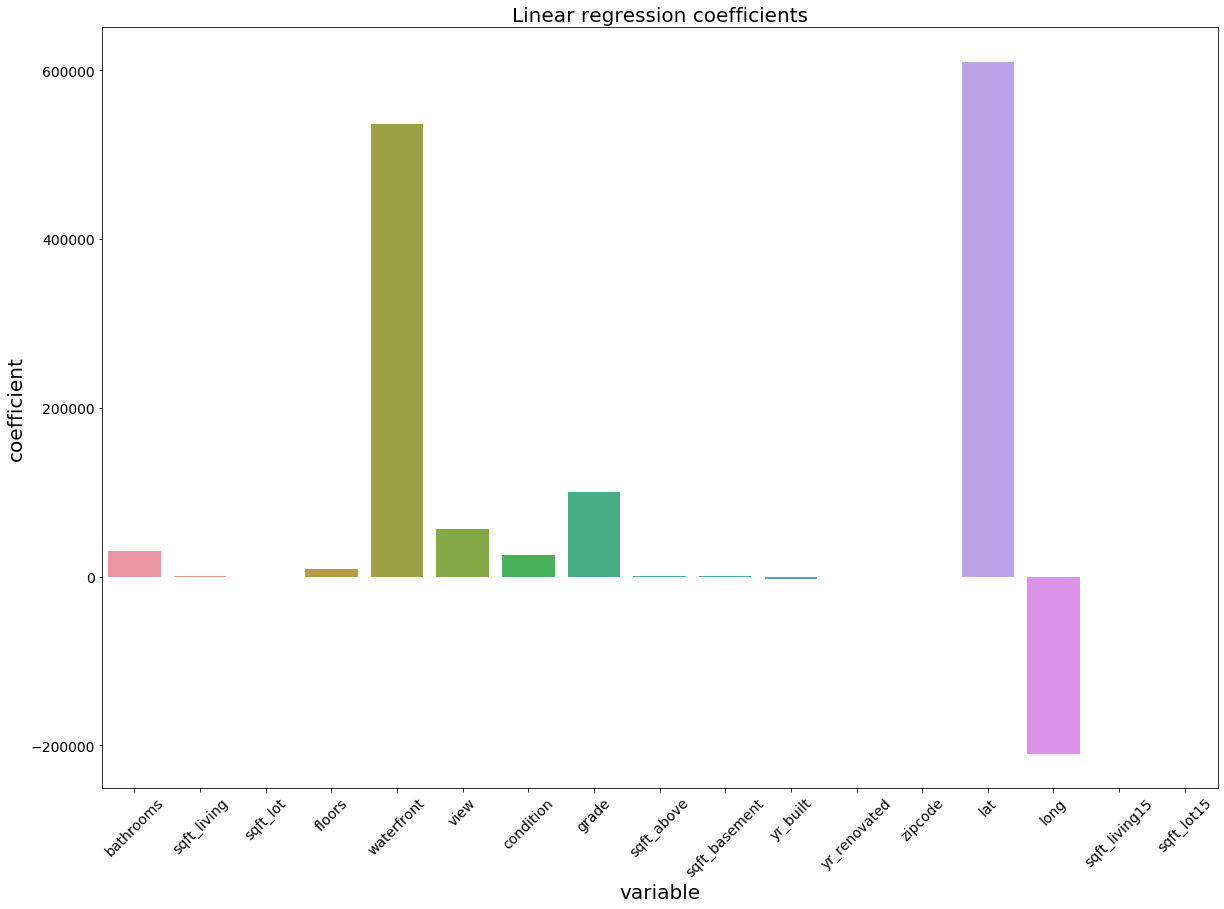

In [7]:
reg = LinearRegression().fit(X_train, y_train)
print(reg)

y_pred = reg.predict(X_test)
y_pred[y_pred <= 0] = 1e-6
reg_loss = msle(y_test, y_pred)
print(f"Regression loss: {reg_loss:.3f}")

for (coef, col) in zip(reg.coef_[0], X_train.columns):
    print(f"{col} - {coef}")

    

plt.figure(figsize = (20,14))
sns.barplot(X_train.columns, reg.coef_[0])
#g.set(ylim=(0.9, 1.25))

plt.title("Linear regression coefficients", fontsize=20)
plt.xlabel("variable", fontsize=20)
plt.ylabel("coefficient", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

#plt.show()
plt.savefig("img/reg_coef.png")

In [8]:
reg_variable_importance = {}

for col in range(len(X_train.columns)):
    loss = 0
    for _ in range(TRIALS):
        X_shuffled = X_train.copy()
        X_shuffled = X_shuffled.reset_index(drop=True)
        X_shuffled.iloc[:, col] = X_shuffled.iloc [:, col] .sample (frac = 1) .reset_index (drop = True)
        X_shuffled = X_shuffled.reset_index(drop=True)

        reg = LinearRegression().fit(X_shuffled, y_train)

        y_pred = reg.predict(X_test)
        y_pred[y_pred <= 0] = 1e-6
        loss += msle(y_test, y_pred)
    
    loss /= TRIALS
    print(f"{X_train.columns[col]} shuffled | Loss: {loss:.3f} | Variable importance: {loss/reg_loss}")
    reg_variable_importance[X_train.columns[col]] = loss/reg_loss

bathrooms shuffled | Loss: 0.885 | Variable importance: 0.9053163868078786
sqft_living shuffled | Loss: 0.975 | Variable importance: 0.9977915435136433
sqft_lot shuffled | Loss: 0.997 | Variable importance: 1.0198047466914835
floors shuffled | Loss: 0.989 | Variable importance: 1.0120022923147438
waterfront shuffled | Loss: 0.943 | Variable importance: 0.9650850441906083
view shuffled | Loss: 1.064 | Variable importance: 1.0888963161500964
condition shuffled | Loss: 1.061 | Variable importance: 1.0856335422943775
grade shuffled | Loss: 0.567 | Variable importance: 0.5801377775120377
sqft_above shuffled | Loss: 0.980 | Variable importance: 1.003151784066286
sqft_basement shuffled | Loss: 0.976 | Variable importance: 0.9985851109192398
yr_built shuffled | Loss: 1.218 | Variable importance: 1.246699707422417
yr_renovated shuffled | Loss: 0.961 | Variable importance: 0.9831506117930104
zipcode shuffled | Loss: 0.949 | Variable importance: 0.9712200462699404
lat shuffled | Loss: 0.588 | Var

In [9]:
with open('reg_2.pickle', 'wb') as handle:
    pickle.dump(reg_variable_importance, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Random forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rf)

y_pred = rf.predict(X_test)
rf_loss = msle(y_test, y_pred)
print(f"Random forest loss: {rf_loss:.3f}")

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Random forest loss: 0.032


In [11]:
rf_variable_importance = {}

for col in range(len(X_train.columns)):
    loss = 0
    for _ in range(TRIALS):
        X_shuffled = X_train.copy()
        X_shuffled = X_shuffled.reset_index(drop=True)
        X_shuffled.iloc[:, col] = X_shuffled.iloc [:, col] .sample (frac = 1) .reset_index (drop = True)
        X_shuffled = X_shuffled.reset_index(drop=True)

        rf = RandomForestRegressor()
        rf.fit(X_shuffled, y_train)

        y_pred = rf.predict(X_test)
        loss += msle(y_test, y_pred)
    loss /= TRIALS
    print(f"{X_train.columns[col]} shuffled | Loss: {loss:.3f} | Variable importance: {loss/rf_loss}")
    rf_variable_importance[X_train.columns[col]] = loss/rf_loss

bathrooms shuffled | Loss: 0.032 | Variable importance: 1.0031518836435291
sqft_living shuffled | Loss: 0.032 | Variable importance: 1.0142910970569157
sqft_lot shuffled | Loss: 0.032 | Variable importance: 1.011811472764011
floors shuffled | Loss: 0.032 | Variable importance: 1.0005895515987235
waterfront shuffled | Loss: 0.032 | Variable importance: 1.0235738087830997
view shuffled | Loss: 0.033 | Variable importance: 1.0261346278217012
condition shuffled | Loss: 0.032 | Variable importance: 1.0167381785428
grade shuffled | Loss: 0.034 | Variable importance: 1.0764707509244225
sqft_above shuffled | Loss: 0.032 | Variable importance: 1.004513659583221
sqft_basement shuffled | Loss: 0.032 | Variable importance: 1.001601793666699
yr_built shuffled | Loss: 0.032 | Variable importance: 1.0073448523085085
yr_renovated shuffled | Loss: 0.032 | Variable importance: 1.00189448510839
zipcode shuffled | Loss: 0.032 | Variable importance: 1.0148621802366438
lat shuffled | Loss: 0.044 | Variable 

In [12]:
with open('rf_2.pickle', 'wb') as handle:
    pickle.dump(rf_variable_importance, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Comparison

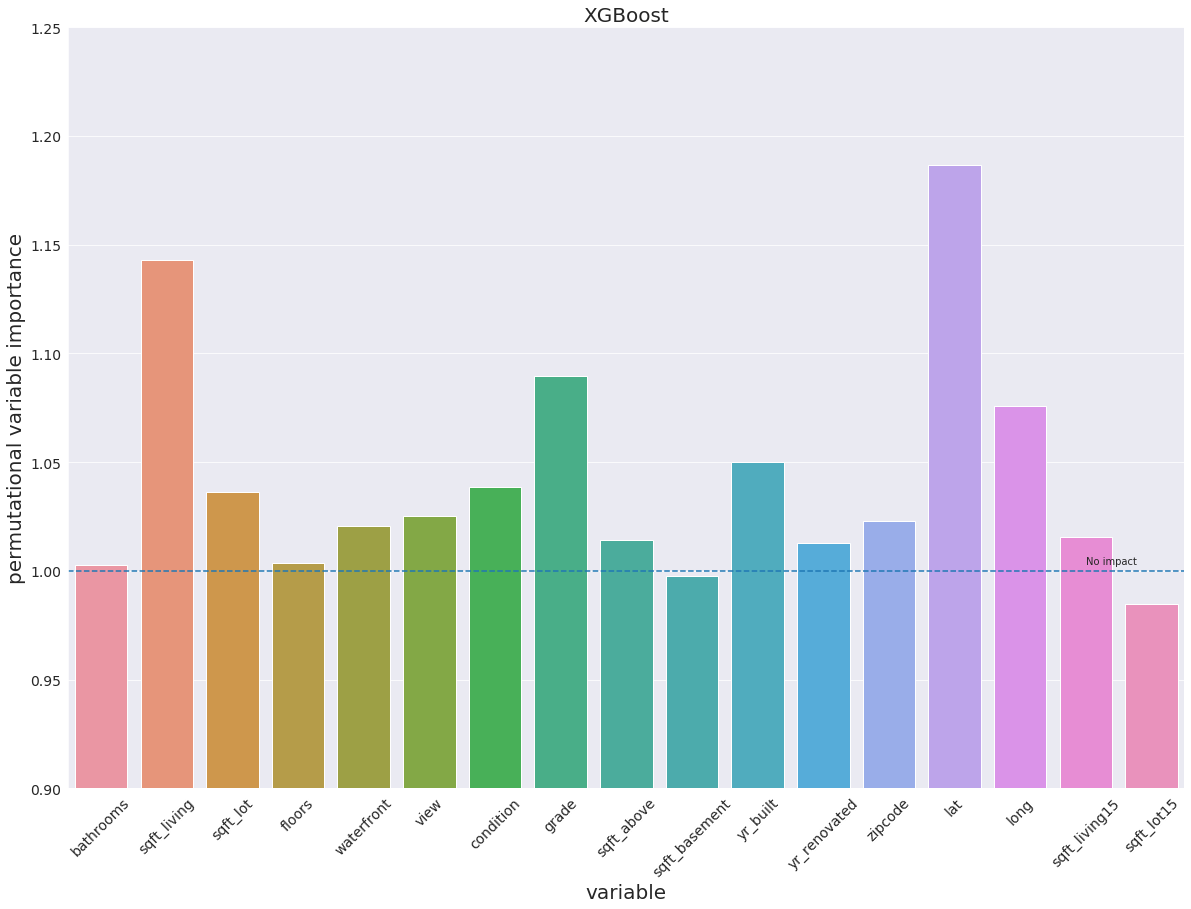

In [13]:
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize = (20,14))
g = sns.barplot(list(xgboost_variable_importance.keys()), list(xgboost_variable_importance.values()))
g.set(ylim=(0.9, 1.25))

plt.title("XGBoost", fontsize=20)
plt.xlabel("variable", fontsize=20)
plt.ylabel("permutational variable importance", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

g.axhline(1, ls='--')
g.text(15,1.003, "No impact")

plt.savefig("img/xgboost.png")

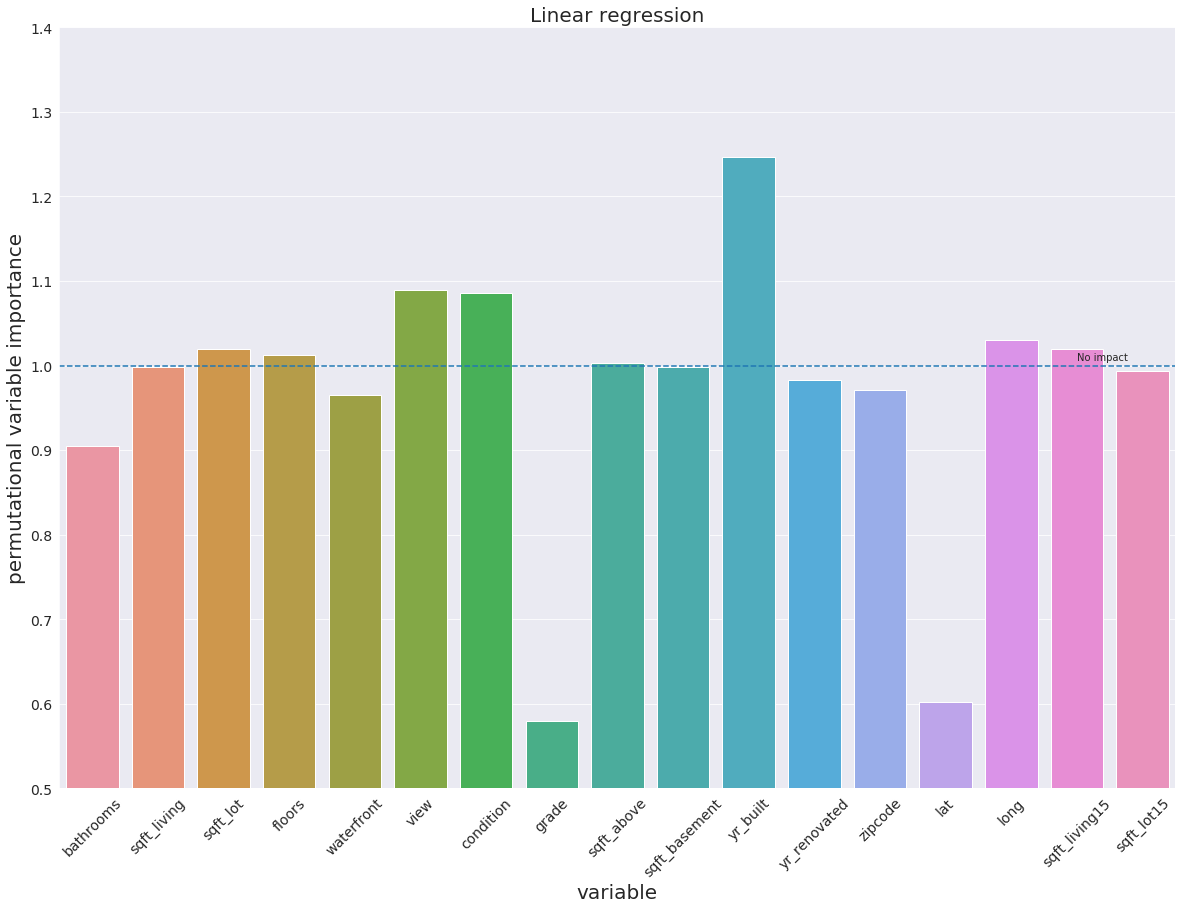

In [14]:
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize = (20,14))
g = sns.barplot(list(reg_variable_importance.keys()), list(reg_variable_importance.values()))
g.set(ylim=(0.5, 1.4))

plt.title("Linear regression", fontsize=20)
plt.xlabel("variable", fontsize=20)
plt.ylabel("permutational variable importance", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

g.axhline(1, ls='--')
g.text(15,1.007, "No impact")

plt.savefig("img/reg.png")

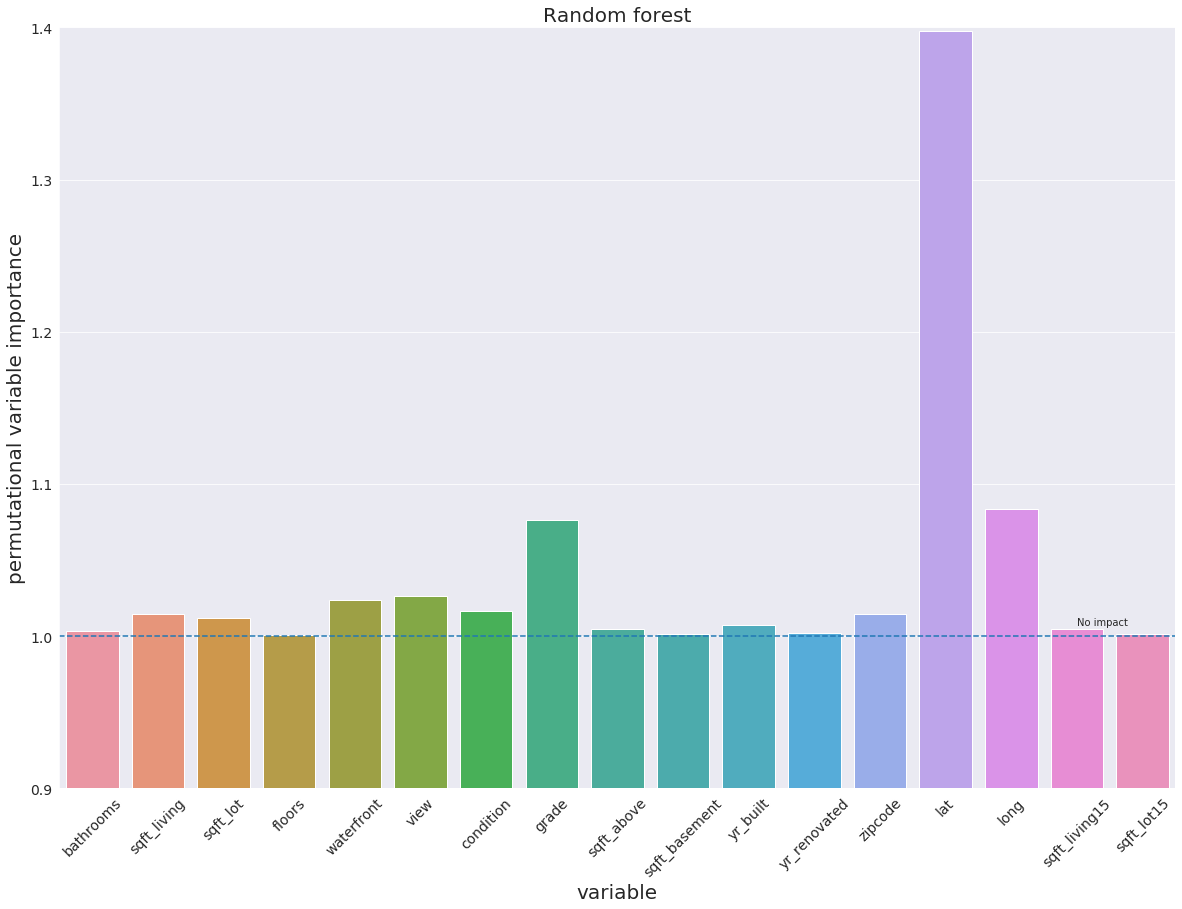

In [15]:
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize = (20,14))
g = sns.barplot(list(rf_variable_importance.keys()), list(rf_variable_importance.values()))
g.set(ylim=(0.9, 1.4))

plt.title("Random forest", fontsize=20)
plt.xlabel("variable", fontsize=20)
plt.ylabel("permutational variable importance", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

g.axhline(1, ls='--')
g.text(15,1.007, "No impact")

plt.savefig("img/rf.png")